# IE 8990 Time Series and Forecasting Course 
## Project I 
#### By Lamiae Taoudi and Saviz Saei

Analyzing household power consumption data to forecast the individual household electric power consumption using the naive base methods and advanced statistical techniques.

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import tensorflow as tf

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.11.0


In [4]:
np.random.seed(42)

## Read and preprocess the data 
Source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [5]:
df = pd.read_csv('household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [7]:
df.shape

(2075259, 9)

In [8]:
# Check for missing values
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [9]:
# Plot Sub_metering_3 to see if there is a noticeable gap in missing values. 
# Useful to see if there are a lot of consecutive 
# missing values.

na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)
len_consecutive_na

Sub_metering_3
6839          2
19722         2
41828         1
61904         1
98248         2
           ... 
1845496       1
1868395       1
1916303    7226
1964211    5237
2001433       1
Name: Sub_metering_3, Length: 71, dtype: int64

In [10]:
longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [11]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


In [12]:
df.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

In [13]:
# Transform all values to numeric except for date and time

cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [14]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

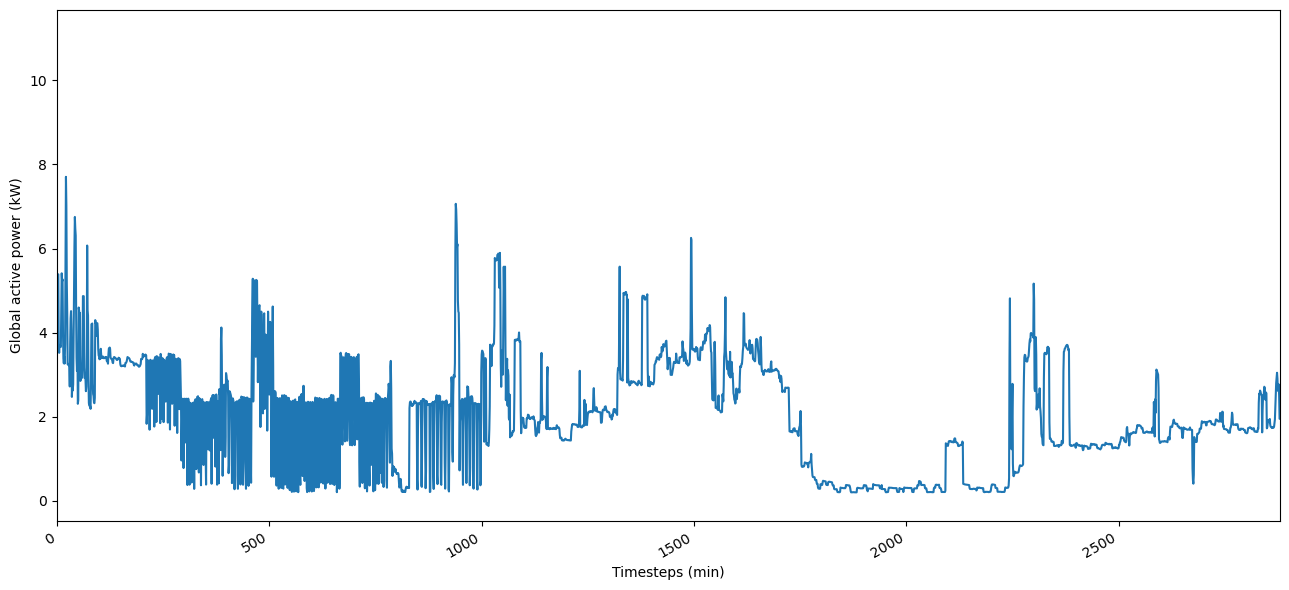

In [15]:
# Plot first 24h (2880 min) of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [17]:
# Sample hourly sum to see if we get a more visible pattern
daily_df = df.resample('D', on='datetime').sum()

daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0


In [18]:
# Drop first and last row of data so that we have only full 24h sums

daily_df = daily_df.drop(daily_df.tail(1).index)
daily_df = daily_df.drop(daily_df.head(1).index)

daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0
2006-12-21,1716.624,144.166,346616.31,7238.6,1765.0,2623.0


In [19]:
daily_df.shape

(1440, 6)

In [20]:
daily_df = daily_df.reset_index()

daily_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0
1,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0
2,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0
3,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0
4,2006-12-21,1716.624,144.166,346616.31,7238.6,1765.0,2623.0


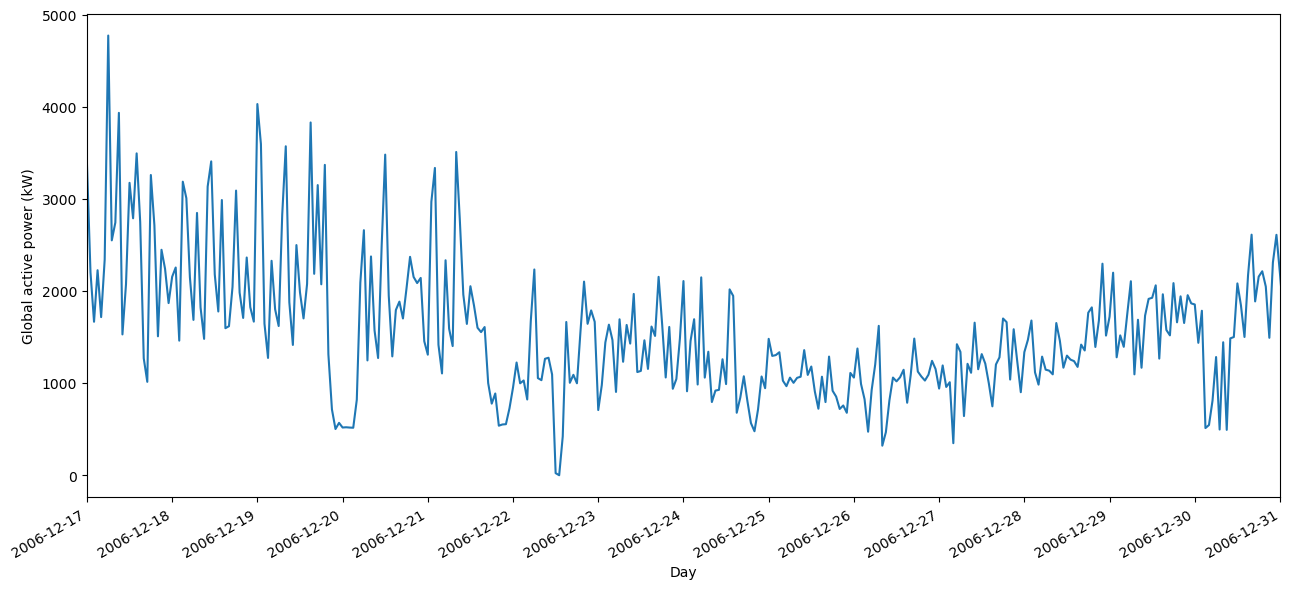

In [21]:
# Plot first 15 full days of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(daily_df['Global_active_power'])
ax.set_xlabel('Day')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
daily_df.to_csv('clean_household_power_consumption.csv', header=True, index=False)

## Feature engineering 

In [23]:
daily_df = pd.read_csv('clean_household_power_consumption.csv')
daily_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0
1,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0
2,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0
3,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0
4,2006-12-21,1716.624,144.166,346616.31,7238.6,1765.0,2623.0


In [24]:
daily_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,1440.0,1551.616376,617.657776,0.0,1160.6755,1536.481,1891.1035,4773.386
Global_reactive_power,1440.0,175.951288,51.881080,0.0,141.1980,170.346,202.4205,417.834
Voltage,1440.0,342466.155590,36128.378008,0.0,345632.0275,346939.345,348251.8425,356306.410
Global_intensity,1440.0,6577.870833,2561.005781,0.0,4987.9500,6515.600,7953.8500,20200.400
Sub_metering_1,1440.0,1595.871528,1588.329068,0.0,560.5000,1109.500,2198.0000,11178.000
Sub_metering_2,1440.0,1847.291667,2090.406037,0.0,424.7500,679.000,2717.7500,12109.000


In [25]:
daily_df = daily_df.drop(['datetime'], axis=1)
print(np.isinf(daily_df).any())


Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
dtype: bool


## Splitting the data and scaling it

#### For Project 1

The data is split into 70% trainning and 30% testing datasets as follows:

In [26]:
n = len(daily_df)
print(n)
# Split 70:30 (train:test)
Pr1_train_df = daily_df[0:int(n*0.7)]
Pr1_test_df = daily_df[int(n*0.7):]
len_Pr1_train = len(Pr1_train_df)

print(len_Pr1_train)
Pr1_train_df.shape, Pr1_test_df.shape


1440
1007


((1007, 6), (433, 6))

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Pr1_train_df)

Pr1_train_df[Pr1_train_df.columns] = scaler.transform(Pr1_train_df[Pr1_train_df.columns])
Pr1_test_df[Pr1_test_df.columns] = scaler.transform(Pr1_test_df[Pr1_test_df.columns])

## Save to CSV files 

In [28]:
Pr1_train_df.to_csv('train_project.csv', index=False, header=True)
Pr1_test_df.to_csv('test_project.csv', index=False, header=True)

### (a) Naive Base Model to forecast Individual household electric power consumption 
#### 1) Historical Mean Prediction

In [29]:
# finding the historical mean 
historical_mean = np.mean(Pr1_train_df['Global_active_power'])
historical_mean

0.3256250875918024

In [30]:
# creating new column for historical mean predictions of Individual household electric power consumption
Pr1_test_df.loc[:, 'pred_mean'] = historical_mean


Looking at the Individual household electric power consumption predictions using the historical mean method

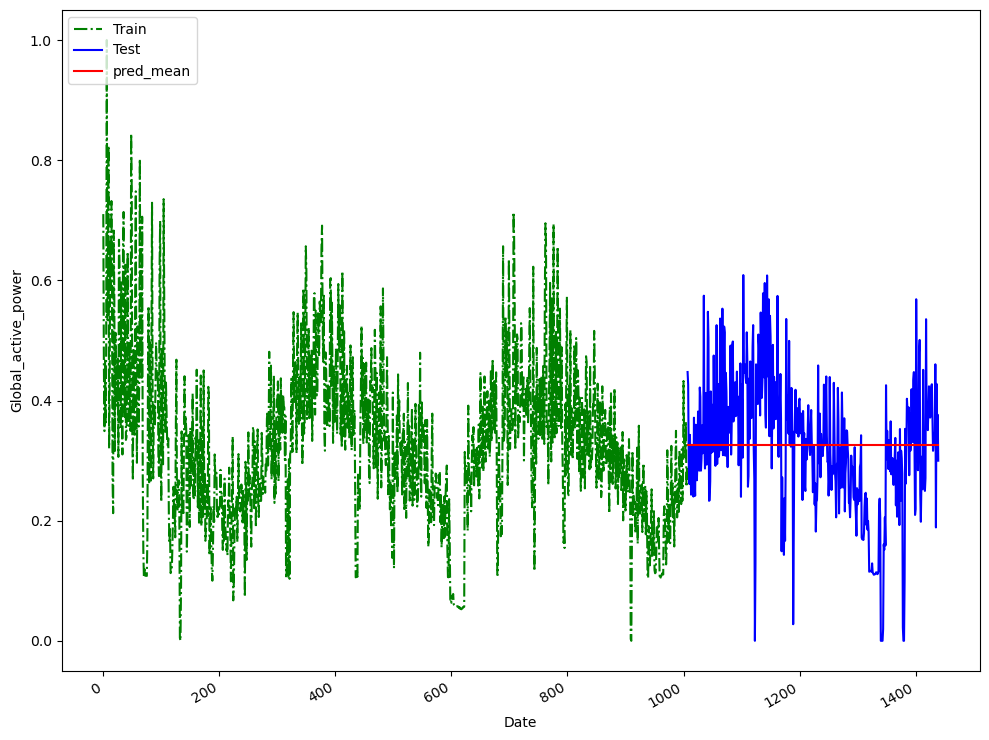

In [32]:
fig, ax = plt.subplots()

ax.plot( Pr1_train_df['Global_active_power'], 'g-.', label= "Train")
ax.plot( Pr1_test_df['Global_active_power'], 'b-', label= "Test")
ax.plot( Pr1_test_df['pred_mean'], 'r-', label= "pred_mean")
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

#### 2) Last Known Value Prediction 


In [33]:
last = Pr1_train_df['Global_active_power'].iloc[-1]
last

0.2878526898935053

In [34]:
Pr1_test_df.loc[:,"pred_last"] = last
last

0.2878526898935053

Looking at the Individual household electric power consumption predictions using the last known value method

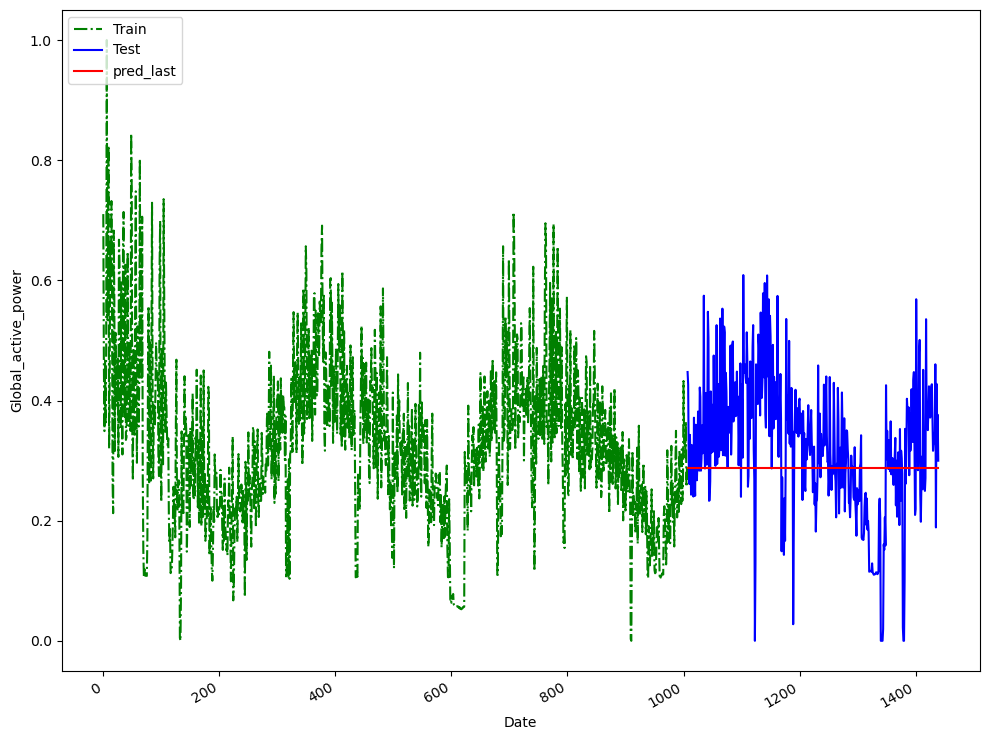

In [35]:
fig, ax = plt.subplots()

ax.plot( Pr1_train_df['Global_active_power'], 'g-.', label= "Train")
ax.plot( Pr1_test_df['Global_active_power'], 'b-', label= "Test")
ax.plot( Pr1_test_df['pred_last'], 'r-', label= "pred_last")
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

To compare the performance of these two naive base models, Mean Absolute Percentage Error is used and is defined below

In [36]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true ))) * 100

In [37]:
# For Historical Mean 
mape_hist_mean = mape(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_mean'])
mape_hist_mean
# For Historical Mean 
mape_hist_mean = mape(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_mean'])
mape_hist_mean

inf

In [38]:
# For Last Known Value
mape_last = mape(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_last'])
mape_last

inf

MAPE will result in division by zero, we decide to consider using other error metrics like Mean Absolute Error (MAE) or Mean Squared Error (MSE).

In [39]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mae_last = mean_absolute_error(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_last'])
mse_last = mean_squared_error(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_last'])

mae_hist_mean = mean_absolute_error(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_mean'])
mse_hist_mean = mean_squared_error(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_mean'])

print("Naive Last Value - MAE:", mae_last, "MSE:", mse_last)
print("hist_mean - MAE:", mae_hist_mean, "MSE:", mse_hist_mean)

Naive Last Value - MAE: 0.09119613920473835 MSE: 0.013699525573311621
hist_mean - MAE: 0.08469642913816619 MSE: 0.012415818740939721


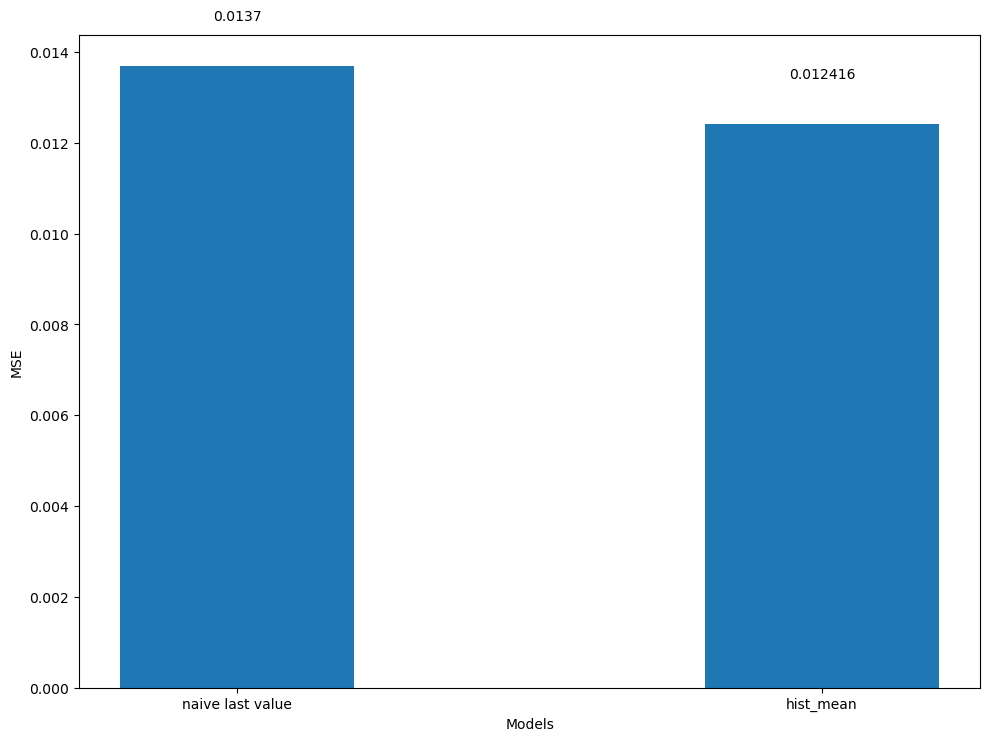

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = ['naive last value', 'hist_mean']
y = [mse_last, mse_hist_mean]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.001, s=str(round(value, 6)), ha='center')

plt.tight_layout()
plt.show()


The historic mean naive base model performs better than naive last known model with a lowest MSE of 0.01618 

## Checking different properties of the data 

Decomposition of the Individual household electric power consumption data can provide insights about the characteristics of the times series data such as trend and seasonality.  

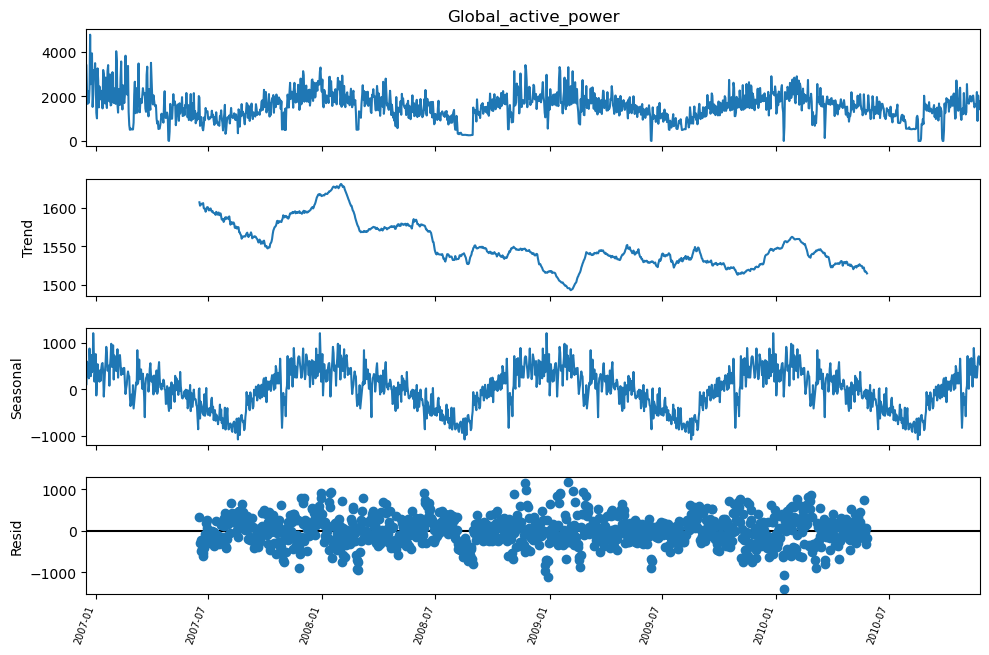

In [41]:

daily_df = pd.read_csv('clean_household_power_consumption.csv')

# Parse the 'datetime' column as a date object
daily_df['datetime'] = pd.to_datetime(daily_df['datetime'], format='%Y-%m-%d')

# Set the 'datetime' column as the index of the DataFrame
daily_df = daily_df.set_index('datetime')

# Select the specific date range
start_date = '2006-12-16'
end_date = '2010-11-26'
selected_data = daily_df.loc[start_date:end_date]

# Choose the column you want to decompose, e.g., 'Global_active_power'
column_to_decompose = 'Global_active_power'

# Specify the period as 365 for daily data with yearly seasonality
# Adjust the period according to the frequency of your data
df_decomp = seasonal_decompose(selected_data[column_to_decompose], period=365)

# Plot the seasonal components
plot = df_decomp.plot()
fig = plt.gcf()
fig.autofmt_xdate(rotation=70)
plt.xticks(fontsize=7)
plot.show()

From the plots above, Individual household electric power consumption shows fluctuations that we apply a moving average to the trend component.

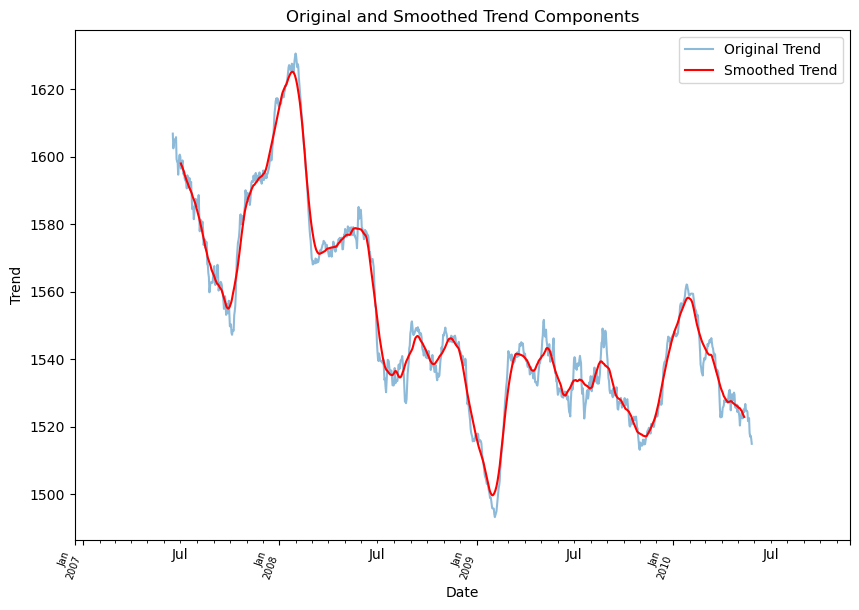

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply a moving average to the trend component
window_size = 30  # You can adjust the window size based on your data
smoothed_trend = df_decomp.trend.rolling(window=window_size, center=True).mean()

# Plot the original trend and the smoothed trend
fig, ax = plt.subplots()
df_decomp.trend.plot(ax=ax, label='Original Trend', alpha=0.5)
smoothed_trend.plot(ax=ax, label='Smoothed Trend', color='red')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Original and Smoothed Trend Components')
fig.autofmt_xdate(rotation=70)
plt.xticks(fontsize=7)
plt.show()


In [43]:
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv("clean_household_power_consumption.csv", parse_dates=True)
ADF_result = adfuller(df['Global_active_power'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.816580786102023
p-value: 0.0027421554671266126


P value is very small therefore we reject the null hypothesis and the clean transformed data is stationary. 


Let's take a look at the autocorrelation plots 

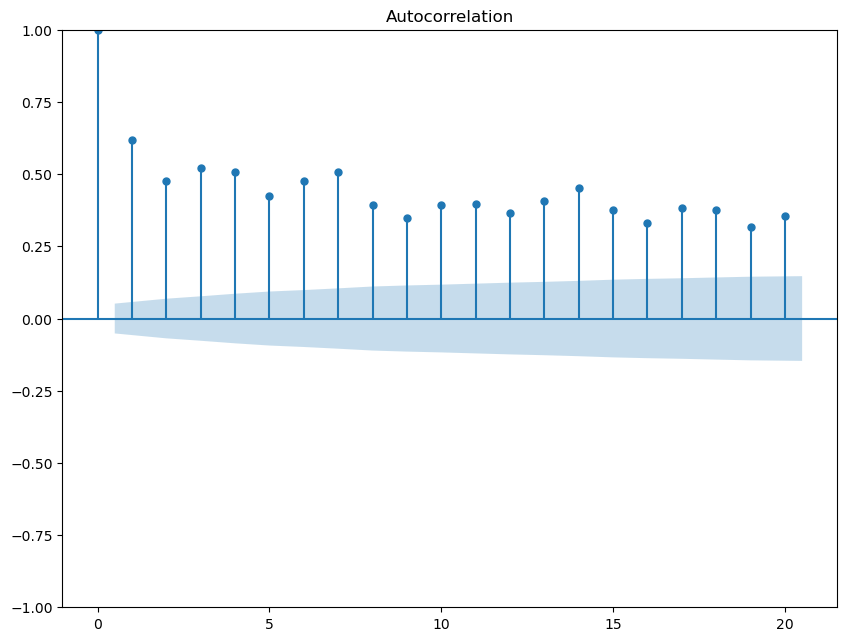

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Global_active_power'], lags=20, alpha=0.05);# alpha=1e-12 can works but it should be 0.05

From the plot above, there is autocorrelation and the autocorrelation coefficients abruptly become nonsignificant after lag .

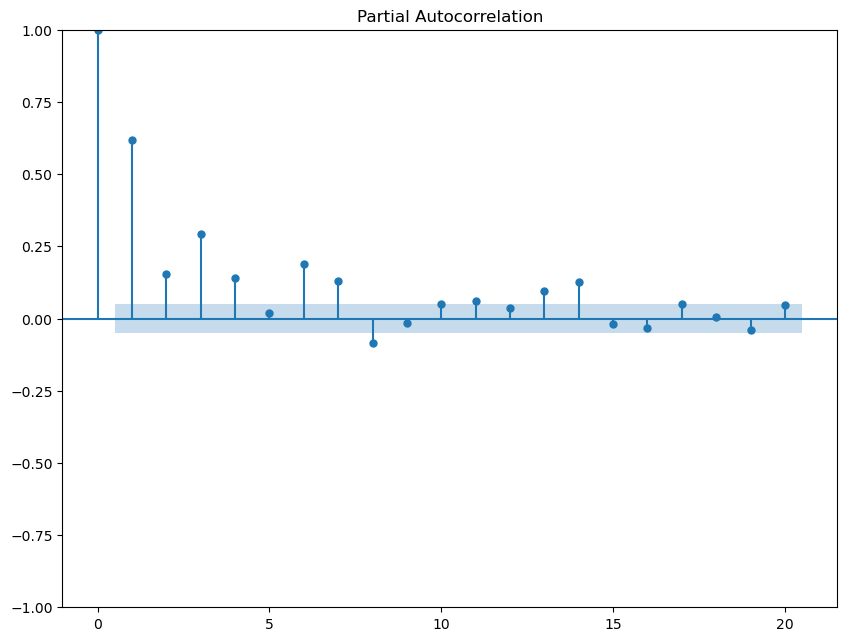

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['Global_active_power'], lags=20, alpha=0.05)
plt.show()

Partial autocorrelation function (PACF) can be used to get more insight into the optimal order of the AR component. 

## ARIMA forecasting of individual household electric power consumption 

In [46]:
# defining a function to optimize ARIMA 
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [47]:
df['Global_active_power'][:len_Pr1_train].tail()

1002    1574.858
1003    1456.806
1004    1743.162
1005    1223.426
1006    1374.032
Name: Global_active_power, dtype: float64

In [48]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

train = Pr1_train_df['Global_active_power'][:len_Pr1_train]
result_df = optimize_ARIMA(train, order_list, d)

result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",-1890.072336
1,"(2, 3)",-1829.616631
2,"(3, 1)",-1819.620368
3,"(3, 2)",-1818.180231
4,"(0, 3)",-1808.778499
5,"(1, 2)",-1808.410160
6,"(2, 2)",-1807.697410
7,"(0, 2)",-1806.889449
8,"(1, 3)",-1806.822440
9,"(2, 1)",-1803.218512


In [49]:
model = SARIMAX(train, order=(3,0,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1007
Model:                SARIMAX(3, 0, 3)   Log Likelihood                 920.618
Date:                 Mon, 08 May 2023   AIC                          -1827.235
Time:                         09:39:28   BIC                          -1792.832
Sample:                              0   HQIC                         -1814.164
                                - 1007                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3135      0.086      3.652      0.000       0.145       0.482
ar.L2          0.0414      0.088      0.471      0.638      -0.131       0.214
ar.L3          0.6418      0.053     12.000 

This shows that the best combination of p and q that decreases AIC is 2 and 2. Therefore, an ARIMA model is fit using p=2, d=0, and q=2.

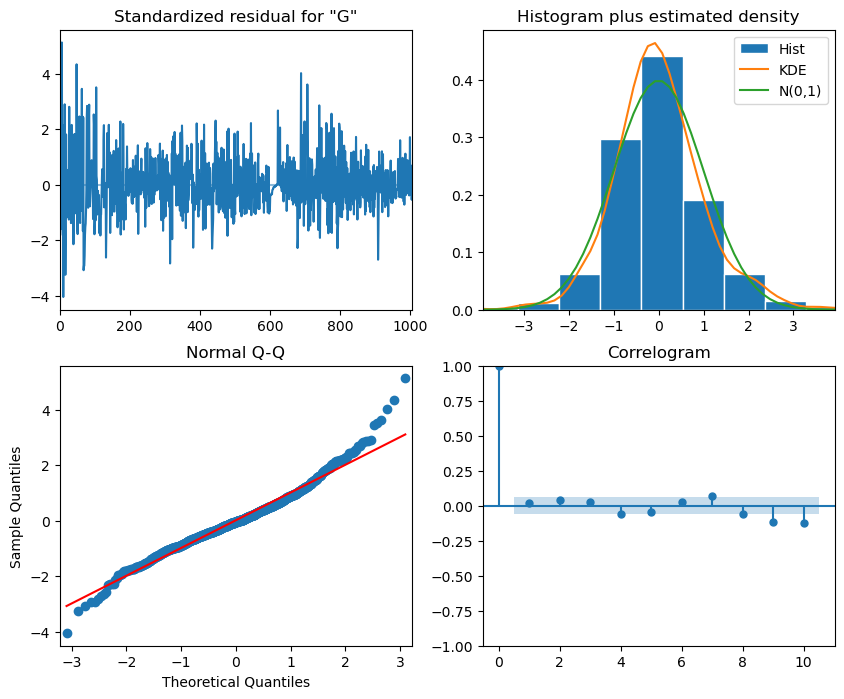

In [50]:
model = SARIMAX(train, order=(3,0,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8));

In [51]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=False)

print(pvalue)

[7.75369108e-01 6.23258831e-01 6.92732610e-01 1.86186853e-01
 1.63525097e-01 8.96938993e-02 4.72632665e-02 3.09992889e-02
 1.56432196e-03 1.04782009e-06]


The residual plots and the results of the Ljungbox test show that the errors are independent and normally distributed. Thus, ARIMA model does not violate the necessary assumptions and can be used to predict Individual household electric power consumption.

In [52]:
# Get the ARIMA predictions for the Pr1_test dataset
start_index = len_Pr1_train
end_index = len(df) - 1
ARIMA_pred = model_fit.get_prediction(start=start_index, end=end_index).predicted_mean

# Add the 'ARIMA_pred' column to the test dataset
Pr1_test_df['ARIMA_pred'] = ARIMA_pred

# Display the test dataset
Pr1_test_df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,pred_mean,pred_last,ARIMA_pred
1435,0.188736,0.286296,0.980245,0.188046,0.000000,0.041787,0.325625,0.287853,0.164066
1436,0.427691,0.340695,0.976250,0.428724,0.434335,0.174251,0.325625,0.287853,0.163833
1437,0.330486,0.328958,0.977788,0.333221,0.167382,0.037823,0.325625,0.287853,0.163601
1438,0.376305,0.317016,0.975574,0.374220,0.098050,0.235197,0.325625,0.287853,0.163369
1439,0.299822,0.277929,0.981693,0.297222,0.096261,0.035180,0.325625,0.287853,0.163137


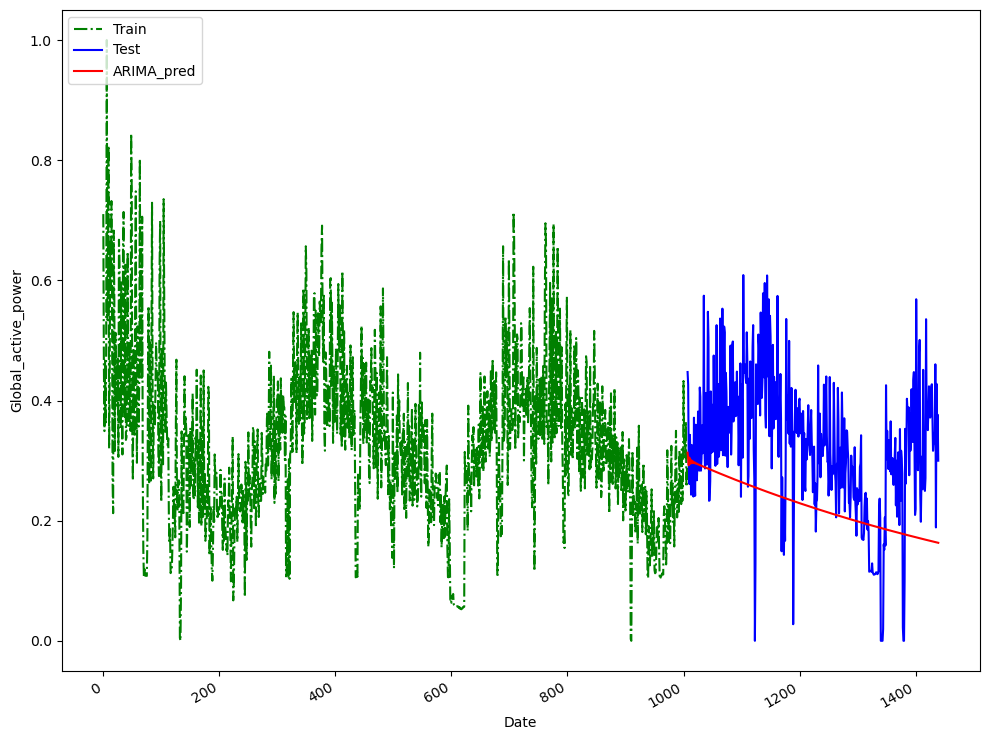

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(Pr1_train_df.index, Pr1_train_df['Global_active_power'], 'g-.', label="Train")
ax.plot(Pr1_test_df.index, Pr1_test_df['Global_active_power'], 'b-', label="Test")
ax.plot(Pr1_test_df.index, Pr1_test_df['ARIMA_pred'], 'r-', label="ARIMA_pred")
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [54]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mae_ARIMA = mean_absolute_error(Pr1_test_df['Global_active_power'], Pr1_test_df['ARIMA_pred'])
mse_ARIMA = mean_squared_error(Pr1_test_df['Global_active_power'], Pr1_test_df['ARIMA_pred'])

print("Last Value - MAE:", mae_last, "MSE:", mae_last)
print("ARIMA - MAE:", mae_ARIMA, "MSE:", mse_ARIMA)


Last Value - MAE: 0.09119613920473835 MSE: 0.09119613920473835
ARIMA - MAE: 0.11962119218248905 MSE: 0.02061355129848009


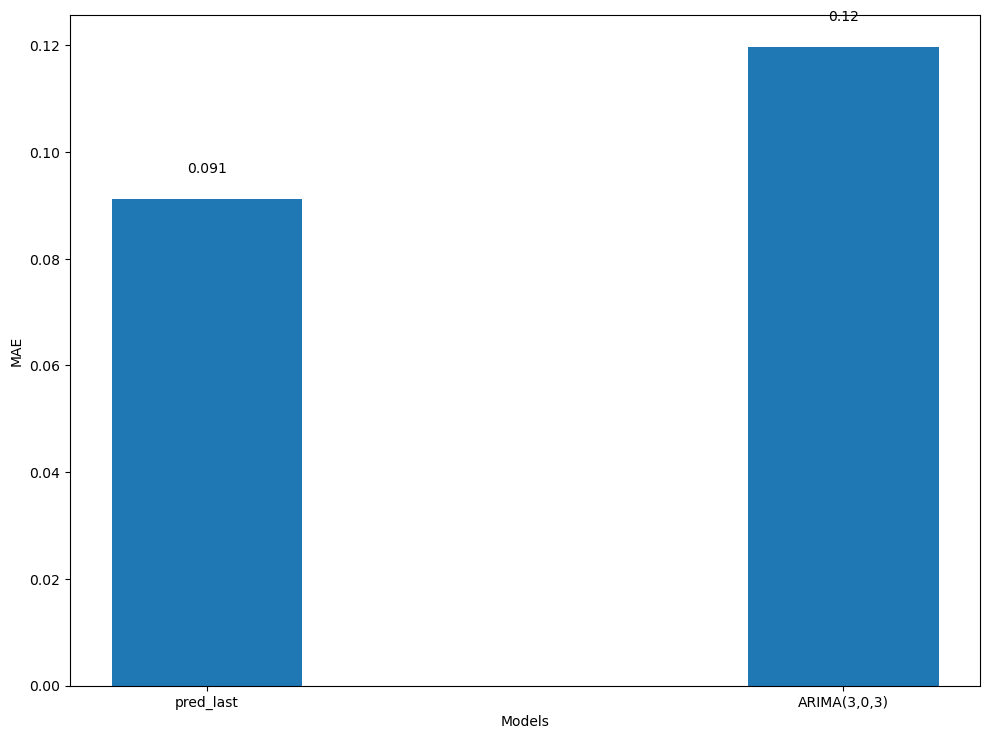

In [56]:
fig, ax = plt.subplots()

x = ['pred_last', 'ARIMA(3,0,3)']
y = [mae_last, mae_ARIMA]

ax.bar(x, y, width=0.3)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
#ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.005, s=str(round(value,3)), ha='center')

plt.tight_layout()

ARIMA model is performing slightly better than the baseline model using the last observed value.

## SARIMAX forecasting of individual household electric power consumption 


In [57]:
target = df['Global_active_power']
exog = df[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']]

In [58]:
from typing import Union
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [59]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [60]:
target_train = target[:len_Pr1_train]
exog_train = exog[:len_Pr1_train]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 2, 0, 0)",8116.286503
1,"(3, 2, 0, 3)",8124.406151
2,"(3, 2, 3, 0)",8130.156069
3,"(3, 2, 1, 0)",8134.994461
4,"(1, 2, 1, 3)",8135.058897
...,...,...
251,"(3, 3, 0, 1)",28032.384322
252,"(1, 3, 0, 1)",29659.857058
253,"(2, 3, 0, 0)",33913.116864
254,"(3, 3, 0, 0)",36343.957955


In [61]:
best_model = SARIMAX(target_train, exog_train, order=(3,0,2), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1007
Model:                SARIMAX(3, 0, 2)   Log Likelihood               -4047.143
Date:                 Mon, 08 May 2023   AIC                           8116.287
Time:                         09:58:38   BIC                           8170.349
Sample:                              0   HQIC                          8136.827
                                - 1007                                         
Covariance Type:                   opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Global_reactive_power    -0.1722      0.015    -11.170      0.000      -0.202      -0.142
Voltage               -2.817e-05   2.18e-05     -1.292      0.196   -7.09e-05    1.46e-05


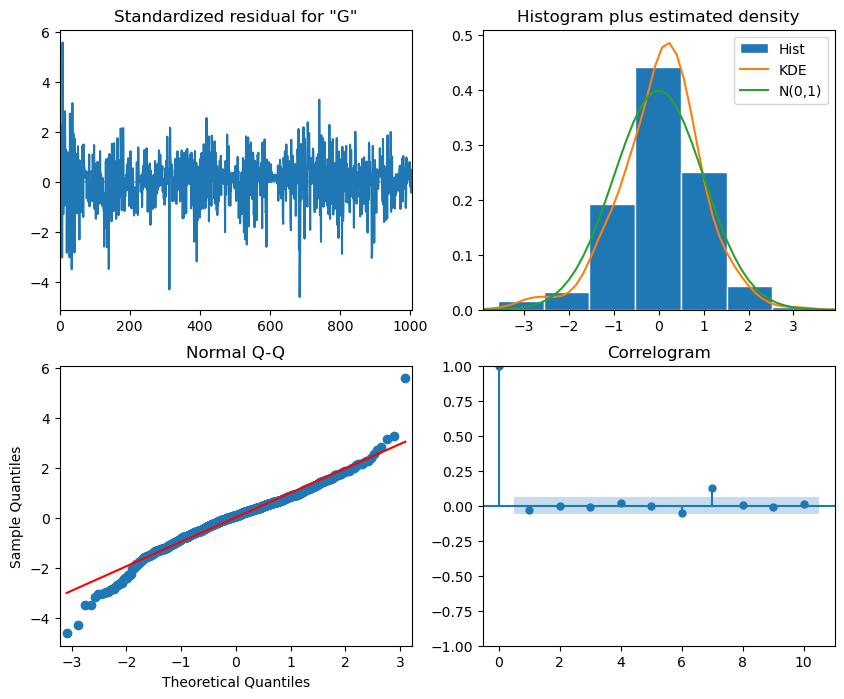

In [62]:
best_model_fit.plot_diagnostics(figsize=(10,8));

Looking at the QQ plot, the residuals follow a normal distribution but there exist some outliers. 

In [63]:
residuals = best_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 10, 1), return_df=False)

print(pvalue)

[0.3473075  0.64258697 0.80991735 0.86704296 0.93834038 0.72026039
 0.00437863 0.00823359 0.01349974]


In [65]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,0,2), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [66]:
target_train = target[:len_Pr1_train]
target_test = target[len_Pr1_train:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')

In [67]:
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df.head()

,actual,pred_last_value,pred_SARIMAX
1007,2135.710,1374.032,1367.381759
1008,2035.328,2135.710,2120.630136
1009,1417.868,2035.328,2034.960333
1010,1246.536,1417.868,1423.414452
1011,1636.610,1246.536,1247.189236


In [68]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100


mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

inf inf


MAPE will result in division by zero, we decide to consider using other error metrics like Mean Absolute Error (MAE) or Mean Squared Error (MSE).

In [69]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mae_last = mean_absolute_error(pred_df.actual, pred_df.pred_last_value)
mse_last = mean_squared_error(pred_df.actual, pred_df.pred_last_value)

mae_SARIMAX = mean_absolute_error(pred_df.actual, pred_df.pred_SARIMAX)
mse_SARIMAX = mean_squared_error(pred_df.actual, pred_df.pred_SARIMAX)

print("Naive Last Value - MAE:", mae_last, "MSE:", mse_last)
print("SARIMAX - MAE:", mae_SARIMAX, "MSE:", mse_SARIMAX)


Naive Last Value - MAE: 345.4626143187067 MSE: 224040.98190071134
SARIMAX - MAE: 344.77128406526606 MSE: 223466.77138293945


Based on the calculated Mean Absolute Error (MAE) and Mean Squared Error (MSE) values, the SARIMAX model has slightly lower errors than the naive last value model

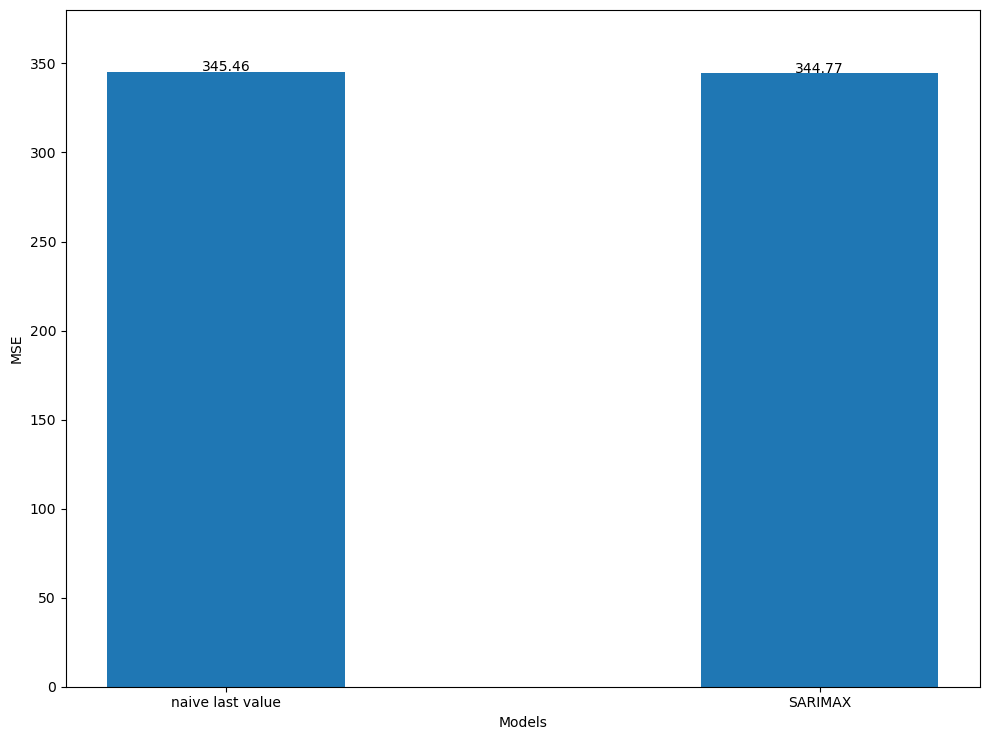

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mae_last, mae_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MSE')
ax.set_ylim(0, max(y) * 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show()
